In [1]:
import math
import os
import pandas as pd
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import chromosomeDefinition as cd
import analyseVCF as aVCF
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
%pprint

Pretty printing has been turned OFF


In [2]:
CNV_COLUMNS = ['chrom','posStart','posEnd','copyNum','gainOrLoss','BAF','score','germlineOrSomatic','oneOrZero']

In [3]:
# LOAD BED
BED_PATH = "/Users/peterpriestley/hmf/analyses/slices/"
BED_FILE_NAME = "cosmicCurated.bed" 
BED_FILE_NAME = "cosmicCancerCensus.bed"
BED_PATH = "/Users/peterpriestley/hmf/analyses/giabTruthsets/"
BED_FILE_NAME = "NA12878_GIAB_highconf_IllFB-IllGATKHC-CG-Ion-Solid_ALLCHROM_v3.2.2_highconf.bed"
#BED_FILE_NAME = "CPCT_Slicing.bed"
USE_BED = True
LOAD_FULL_FILE = True

### FUNCTIONS

In [4]:
def findFiles(path,suffix):
    files=[]
    for x in os.listdir(path):
        if x[-len(suffix):] == suffix:
            files.append(x)
    return files

In [5]:
def loadCNVforPatient(cnvFile,patientName):
    dfCNV = pd.read_table(cnvFile, names = CNV_COLUMNS )
    #print dfCNV
    #add regions with default copy number
    last = dfCNV.iloc[0]
    for i in range(1, dfCNV.shape[0]-1):
        #print last.chrom,last.posStart,last.posEnd
        if last['posEnd']<>dfCNV.iloc[i]['posStart']:
            if last['chrom']==dfCNV.iloc[i]['chrom']:
                dfCNV.loc[len(dfCNV)] = [last['chrom'],last['posEnd'], dfCNV.iloc[i]['posStart']-1,2,'none','-','-','-','-']
            else:
                dfCNV.loc[len(dfCNV)] = [last['chrom'],last['posEnd'], cd.chromosomeLength[last['chrom']],2,'none','-','-','-','-']
                if dfCNV.iloc[i]['posStart']<>0:
                    dfCNV.loc[len(dfCNV)] = [dfCNV.iloc[i]['chrom'],0, dfCNV.iloc[i]['posStart'],2,'none','-','-','-','-']
        last = dfCNV.iloc[i]
    #fix first record
    if dfCNV.iloc[0]['posStart']<>0:
        dfCNV.loc[len(dfCNV)] = ['1',0, dfCNV.iloc[0]['posStart'],2,'none','-','-','-','-']
    #Additional Fields
    dfCNV['chromPos']= dfCNV['chrom'].apply(lambda x: cd.intChrom(x)) + dfCNV['posStart'] / dfCNV['chrom'].apply(lambda x: cd.chromosomeLength[str(x)])
    dfCNV['chrom'] = dfCNV['chrom'].apply(lambda x: cd.intChrom(x))
    dfCNV['cappedCopyNum'] = dfCNV['copyNum'].clip(upper=5)
    dfCNV = dfCNV.sort_values(["chrom","posStart","posEnd"]).reset_index()
    dfCNV['regionLength'] = (dfCNV['posEnd']-dfCNV['posStart'])
    dfCNV['patientName']=patientName
    return dfCNV

In [6]:
def nonZeroCountBetween(chrom,minPos,maxPos):
    temp = dfTumorRatio[(dfTumorRatio.Chromosome==chrom)&(dfTumorRatio.Start>minPos)&\
                       (dfTumorRatio.Start<maxPos)&(dfTumorRatio.Ratio_x<>-1)]
    return temp['Start'].count(),temp['Ratio_x'].mean(),temp['Ratio_y'].mean(),temp['MedianRatio_x'].mean(),temp['MedianRatio_y'].mean()

In [7]:
def fitBAFPeak(mBAF):
    return min(mBAFPeaks, key=lambda x:abs(x-mBAF))

def fitCNVPeak(ratio):
    return min(cnvPeaks, key=lambda x:abs(x-ratio))

In [155]:
def patientIDFromFilename(filename,findKey):
    patientIDStart = filename.find(findKey)   #
    return filename[patientIDStart:patientIDStart+12]

In [9]:
def loadVCF(path,filename,sampleNames,patientID):
    df = pd.DataFrame()
    if USE_BED:
        bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)
        return pd.concat([df,aVCF.loadVariantsFromVCF(path,filename,sampleNames,patientID,True,True,bed,LOAD_FULL_FILE)])
    else:
        return pd.concat([df,aVCF.loadVariantsFromVCF(path,filename,sampleNames,patientID,True)])

In [10]:
def calculateMBAFBetween(chrom,minPos,maxPos):
    dftemp = dfBAF[(dfBAF.Chromosome==chrom)&(dfBAF.Position>minPos)&(dfBAF.Position<maxPos)]
    return dftemp['mBAF'].median(),dftemp['mBAF'].count()

In [11]:
def createBAF(dfGermline):
    dfBAF = dfGermline[(dfGermline['variantType']=="SNP")&(dfGermline['normalSGT']=="0/1")&(dfGermline['normalAF']>0.4) \
                   &(dfGermline['normalAF']<0.65)&(dfGermline['normalDP']>30)&\
                   (dfGermline['normalDP']<100)][['chrom','pos','tumorAF']]
    dfBAF.columns = ['Chromosome', 'Position','BAF']
    dfBAF['Position'] = pd.to_numeric(dfBAF['Position'])
    dfBAF['mBAF']= 0.5+abs(dfBAF['BAF']-0.5)
    dfBAF['chromPos']= dfBAF['Chromosome'].apply(lambda x: cd.intChrom(x)) + dfBAF['Position'] / dfBAF['Chromosome'].apply(lambda x: cd.chromosomeLength[str(x)])
    dfBAF['Chromosome']= dfBAF['Chromosome'].apply(lambda x: cd.intChrom(x))
    return dfBAF

In [12]:
def positionChart(dfCNV,filename,fieldName,minChrom=1,maxChrom=23,maxValue=10):
    plt.figure(figsize=[18,3])
    plt.title(filename+" "+fieldName)
    ax = plt.gca()
    ax.plot(dfCNV['chromPos'], dfCNV[fieldName],drawstyle="steps-post")
    ax.axis([minChrom, maxChrom, 0, maxValue])

In [13]:
def AFByPosPlot(pos,AF,startChartPos,endChartPos):
    plt.figure(figsize=[18,3])
    plt.scatter(pos, AF)
    plt.grid(b=True, which='both', color='0.65',linestyle='-')
    plt.axis([startChartPos, endChartPos,0, 1.0])
    plt.show()

In [14]:
def findPeaks(log_dens,X_range):
    peaks = []
    troughs = []
    dens=np.exp(log_dens)
    diff = [dens[x] - dens[x-1] for x in range(1,len(dens))]
    for i in range (len(diff)-1):
        if diff[i+1] < 0 and diff[i] > 0:
            peaks.append(float(i+1)/len(dens)*X_range)
        if diff[i+1] > 0 and diff[i] < 0:
            troughs.append(float(i+1)/len(dens)*X_range)
    return peaks#, troughs

In [175]:
def fitCNVPurity(tumorCNV,CNVRatioWeightFactor,minPurity,maxPurity,
                 stepsPurity,minCNVNormFactor,maxCNVNormFactor,stepsCNVNormFactor,printDetail=False):
    fitResults = []
    sumWeight = sum([(tumorCNV[x][1]) for x in range(1,len(tumorCNV))])
    for purity in np.linspace(minPurity,maxPurity,stepsPurity):
        for CNVNormalisationFactor in np.linspace(minCNVNormFactor,maxCNVNormFactor,stepsCNVNormFactor):
            samplePloidy = (1-CNVNormalisationFactor)/(CNVNormalisationFactor/purity*2)+2
            if samplePloidy > 0.9:
                modelDeviation, diploidProportion, modelBAFDeviation = 0,0,0
                for i in range(0, len(tumorCNV)):
                    if tumorCNV[i][1] > 0 and  tumorCNV[i][2] >= 0 : #
                        # Should also correct for mBAF < 0.5
                        minDeviation,bestFittedBAF,fittedPloidy,BAFOnlyDeviation = 1e9,0,0,0  #reset variables
                        for ploidy in range(1,14):
                            modelCNVratio = CNVNormalisationFactor + (ploidy-2)*purity*CNVNormalisationFactor/2
                            CNVDeviation = CNVRatioWeightFactor*abs(modelCNVratio-tumorCNV[i][2]) #OR TUMOR RATIO???
                            for BAF in range(int(math.ceil(ploidy/2.0)),ploidy+1):
                                modelBAF = max(0.535,(1+purity*(BAF-1))/(2+purity*(ploidy-2)))
                                if minDeviation > (max(ploidy,2.0) /2.0)**0.85*(abs(modelBAF-tumorCNV[i][0]) + CNVDeviation):
                                    minDeviation = (max(ploidy,2.0) /2.0)**0.85*(abs(modelBAF-tumorCNV[i][0]) + CNVDeviation)
                                    BAFOnlyDeviation = abs(modelBAF-tumorCNV[i][0])
                                    bestFittedBAF = modelBAF
                                    fittedPloidy = ploidy
                        modelDeviation = modelDeviation + tumorCNV[i][1]/sumWeight*minDeviation*tumorCNV[i][0]
                        modelBAFDeviation = modelBAFDeviation + tumorCNV[i][1]/sumWeight*BAFOnlyDeviation*tumorCNV[i][0]
                        if fittedPloidy == 2:
                            diploidProportion = diploidProportion + tumorCNV[i][1] / sumWeight
                    if printDetail and tumorCNV[i][1] >= 10:
                        print purity,CNVNormalisationFactor,bestFittedBAF,fittedPloidy,minDeviation,BAFOnlyDeviation,tumorCNV[i][0],tumorCNV[i][1],tumorCNV[i][2],tumorCNV[i][4],tumorCNV[i][5],tumorCNV[i][6],samplePloidy
                fitResults.append([purity,CNVNormalisationFactor, modelDeviation,modelBAFDeviation,diploidProportion])
    dfFitOutput = pd.DataFrame(sorted(fitResults, key=lambda x: x[2]))
    dfFitOutput.columns = ["purity","NormFactor",'score','modelBAFDeviation','diploidProportion']
    return dfFitOutput

### ANALYSIS

In [279]:
PATH="/Users/peterpriestley/hmf/analyses/v1.12samples/CPCT02010499/"
#PATH="/Users/peterpriestley/hmf/analyses/COLO829/"
tumorCNVFileName=findFiles(PATH,"gz_CNVs")[0]
normalCNVFileName=findFiles(PATH,"normal_CNVs")[0]
tumorRatioFileName=findFiles(PATH,"gz_ratio.txt")[0]
normalRatioFileName=findFiles(PATH,"gz_normal_ratio.txt")[0]
germlineVCFFilename = findFiles(PATH,"SLICED.vcf")[0]
patientID = patientIDFromFilename(germlineVCFFilename,"CPCT0")
#patientID = "COLO829"
print "germline =",germlineVCFFilename
print "patient =",patientID
print "CNV =",tumorCNVFileName

germline = 170411_HMFregCPCT_FR12245152_FR10244748_CPCT02010499.annotatedSLICED.vcf
patient = CPCT02010499
CNV = CPCT02010499T_dedup.realigned.pileup.gz_CNVs


In [280]:
dfGermline = loadVCF(PATH,germlineVCFFilename,{patientID+'R':'normal',patientID+'T':'tumor'},patientID)
#dfGermline = loadVCF(PATH,germlineVCFFilename,{patientID+'BL':'normal',patientID+'':'tumor'},patientID)

reading vcf file: 170411_HMFregCPCT_FR12245152_FR10244748_CPCT02010499.annotatedSLICED.vcf
reading VCF File line: 1
reading VCF File line: 200001
Number variants loaded: 344514


In [281]:
dfBAF = createBAF(dfGermline)

In [282]:
len(dfBAF)

129897

In [283]:
patientName=normalCNVFileName[:12]
dfTumorCNV = loadCNVforPatient(PATH+tumorCNVFileName,patientName)
dfNormalCNV = loadCNVforPatient(PATH+normalCNVFileName,patientName)

In [284]:
dfTumorCNV['mBAF'], dfTumorCNV['mBAFCount'] = \
    np.vectorize(calculateMBAFBetween)(dfTumorCNV['chrom'], dfTumorCNV['posStart'],dfTumorCNV['posEnd'])

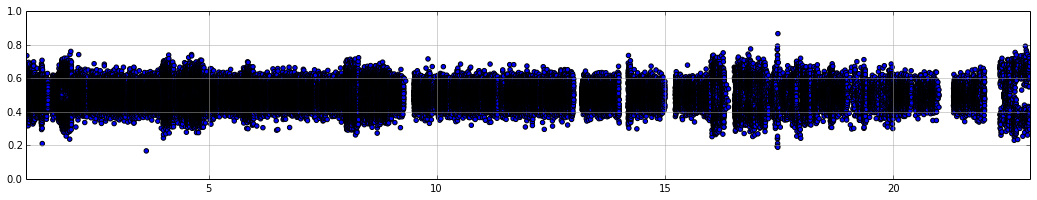

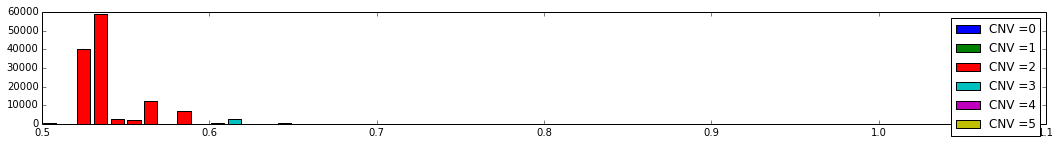

In [285]:
c, fractionMin, fractionMax = 1,0,22
dfSom = dfBAF[(dfBAF.chromPos>c+fractionMin)&(dfBAF.chromPos<c+fractionMax)]
AFByPosPlot(dfSom.chromPos, dfSom.BAF,c+fractionMin, c+fractionMax)

dftemp = dfTumorCNV[(dfTumorCNV.mBAF>=0.0)&(dfTumorCNV.mBAF<=1.0)&(dfTumorCNV.mBAFCount>20)&(dfTumorCNV.chromPos<=c+fractionMax)&(dfTumorCNV.chromPos>=c+fractionMin)]
plt.figure(figsize=[18,2])
for CNV in range(0,6):
    plt.hist(dftemp[(dftemp.copyNum==CNV)]['mBAF'].values,cumulative=False, normed=False, bins=50,range=(0.5,1.0),weights=dftemp[(dftemp.copyNum==CNV)]['mBAFCount'].values,stacked = True,rwidth=0.8,label='CNV ='+str(CNV))
    plt.legend()
plt.show()

In [286]:
#dfTumorCNV[(dfTumorCNV.mBAF>0.74)&(dfTumorCNV.mBAF<0.77)&(dfTumorCNV.mBAFCount>300)]

### Ratio calculations

In [287]:
dfTumorRatio = pd.read_table(PATH + tumorRatioFileName, header=0)
dfNormalRatio = pd.read_table(PATH + normalRatioFileName, header=0)
dfTumorRatio.set_index(['Chromosome','Start'],inplace=True)
dfNormalRatio.set_index(['Chromosome','Start'],inplace=True)
dfTumorRatio = pd.merge(dfTumorRatio,dfNormalRatio,how='inner', left_index=True,right_index=True)
dfTumorRatio['ratio']= pd.to_numeric(dfTumorRatio['Ratio_x'],errors=coerce) /pd.to_numeric(dfTumorRatio['Ratio_y'],errors=coerce)
dfTumorRatio = dfTumorRatio.reset_index()
dfTumorRatio['chromPos'] = dfTumorRatio['Chromosome'].apply(lambda x: cd.intChrom(str(x))) + \
    dfTumorRatio['Start']/dfTumorRatio['Chromosome'].map(lambda x: cd.chromosomeLength[str(x)])
dfTumorRatio['Chromosome'] = dfTumorRatio['Chromosome'].apply(lambda x: cd.intChrom(str(x)))

In [288]:
dfTumorCNV['nonZeroCount'],dfTumorCNV['tumorRatio'],dfTumorCNV['normalRatio'] \
    ,dfTumorCNV['tumorMedianRatio'],dfTumorCNV['normalMedianRatio'] = \
    np.vectorize(nonZeroCountBetween)(dfTumorCNV['chrom'], dfTumorCNV['posStart'],dfTumorCNV['posEnd'])
dfTumorCNV['ratioOfRatio']=dfTumorCNV.tumorRatio/dfTumorCNV.normalRatio

### PEAK FINDING

In [289]:
#X = dfTumorCNV[dfTumorCNV.nonZeroCount>10].ratioOfRatio.sort_values()[:, np.newaxis]
X_range = 5
X_plot = np.linspace(0,X_range,1000)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.007).fit(dfTumorCNV[(dfTumorCNV.nonZeroCount>10)].tumorRatio.sort_values()[:, np.newaxis])
log_dens = kde.score_samples(X_plot)
cnvPeaks = findPeaks(log_dens,X_range)
X_range = 1
X_plot = np.linspace(0,X_range,1000)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.003).fit(dfTumorCNV[dfTumorCNV.mBAFCount>10].mBAF.sort_values()[:, np.newaxis])
log_dens = kde.score_samples(X_plot)
mBAFPeaks = findPeaks(log_dens,X_range)

In [290]:
dfTumorCNV['fittedBAFPeak'] = np.vectorize(fitBAFPeak)(dfTumorCNV['mBAF'])
dfTumorCNV['fittedCNVPeak'] = np.vectorize(fitCNVPeak)(dfTumorCNV['tumorRatio'])
pd.pivot_table(dfTumorCNV[dfTumorCNV.chrom<23], values='mBAFCount', index=['fittedBAFPeak'], columns=['fittedCNVPeak'], aggfunc='sum',margins=True).fillna("")

fittedCNVPeak,0.215,0.325,0.4,0.43,0.48,0.515,0.665,0.69,0.715,0.75,0.8,0.835,0.86,0.875,0.915,0.94,0.975,1.01,1.09,1.135,1.16,1.205,1.24,1.3,1.34,...,2.34,2.37,2.39,2.42,2.455,2.685,2.775,2.94,3.04,3.06,3.14,3.175,3.33,3.425,3.505,3.535,3.66,3.85,3.99,4.09,4.21,4.235,4.785,4.945,All
fittedBAFPeak,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.53,0,0,0,0,0,1,0,5,0,37,74,0,10,528,584,1760,28871,58375,7555,0,128,27,4,28,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,98034.0
0.563,1,,,,,,,,,,2,303,38,2,404,755,6365,790,1438,981,4760,,,8,11,...,1,,,,,,,,,,,,,,,,,,,,,,,,15865.0
0.587,,,,,,,35,,61,72,1466,3434,164,,1692,,57,13,1,4,,,,,,...,,,,,,,,1,,,,,,,,,,1,,,,,,,7017.0
0.615,,,,,,,,,,1,139,34,,296,20,,,42,,,108,,1643,803,407,...,,,,,,,,,,,,,,,,,,,,,,,,,3618.0
0.646,,,,,,,,,,,3,,,,255,105,,,,34,,,,74,,...,,,,,,,,,,,,,,,,,,,,,,,,,534.0
0.655,,,,,,,,,,,,,3,,153,13,,,,,,15,,,,...,,,,,,,,,,,,,,,,,,,,,,,,,238.0
0.697,,,,,,,,,,,,,,2,,,,11,,,,,,,,...,,,,,,1,,,1,,,,,,,,,,,,,,,,45.0
All,1,0,0,0,0,1,35,5,61,110,1684,3771,215,828,3108,2633,35293,59231,8994,1019,4996,42,1647,913,418,...,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,125351.0


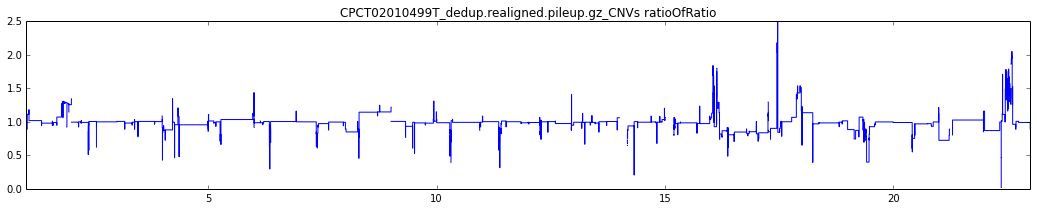

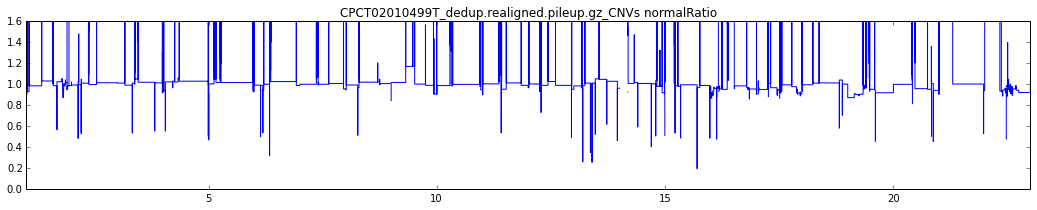

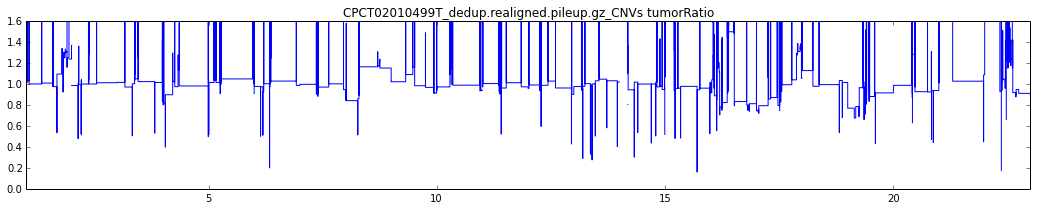

In [291]:
positionChart(dfTumorCNV,tumorCNVFileName,"ratioOfRatio",1,23,2.5)
positionChart(dfTumorCNV,tumorCNVFileName,"normalRatio",1,23,1.6)
positionChart(dfTumorCNV,tumorCNVFileName,"tumorRatio",1,23,1.6)

In [292]:
dfTumorCNV[(dfTumorCNV.chrom==1)&(dfTumorCNV.mBAFCount>100)]

,index,chrom,posStart,posEnd,copyNum,gainOrLoss,BAF,score,germlineOrSomatic,oneOrZero,chromPos,cappedCopyNum,regionLength,patientName,mBAF,mBAFCount,nonZeroCount,tumorRatio,normalRatio,tumorMedianRatio,normalMedianRatio,ratioOfRatio,fittedBAFPeak,fittedCNVPeak
4,474,1,5735000,16848999,2,none,-,-,-,-,1.023009,2,11113999,CPCT02010499,0.565628,214,9809,1.031404,0.928884,1.034427,0.927267,1.110369,0.563,1.010
7,475,1,17270000,85979999,2,none,-,-,-,-,1.069288,2,68709999,CPCT02010499,0.539130,2382,64633,1.002200,0.983941,1.004162,0.981998,1.018557,0.530,1.010
9,476,1,86005000,144842999,2,none,-,-,-,-,1.345054,2,58837999,CPCT02010499,0.532374,1783,31873,1.010585,1.030462,1.005759,1.014299,0.980711,0.530,1.010
18,479,1,149239000,169218999,2,none,-,-,-,-,1.598751,2,19979999,CPCT02010499,0.528956,734,17848,0.976396,0.985596,0.979692,0.982649,0.990665,0.530,0.975
20,480,1,169241000,194705999,2,none,-,-,-,-,1.678999,2,25464999,CPCT02010499,0.548826,1380,23982,1.096650,1.023483,1.097678,1.020991,1.071488,0.563,1.090
21,13,1,194706000,199665000,3,gain,AAB,0.219291,somatic,0,1.781166,3,4959000,CPCT02010499,0.613095,349,4602,1.339568,1.052037,1.342510,1.048434,1.273308,0.615,1.340
22,14,1,199665000,202738000,3,gain,AAB,1.55661,somatic,0,1.801061,3,3073000,CPCT02010499,0.610465,157,2801,1.240551,0.951223,1.241350,0.951526,1.304165,0.615,1.240
25,16,1,205880000,210077000,3,gain,AAB,0.37466,somatic,0,1.825996,3,4197000,CPCT02010499,0.616284,142,3478,1.305784,1.003672,1.307980,0.992216,1.301008,0.615,1.300
26,17,1,210077000,213412000,3,gain,AAB,1.09256,somatic,0,1.842834,3,3335000,CPCT02010499,0.623192,130,3121,1.253755,0.983345,1.256370,0.993583,1.274990,0.615,1.240
29,20,1,215853000,224076000,3,gain,AAB,0.115575,somatic,0,1.866008,3,8223000,CPCT02010499,0.610280,562,7721,1.307458,1.013782,1.311090,1.013299,1.289683,0.615,1.300


In [298]:
dfTumorCNV[(dfTumorCNV.tumorRatio<0.95)&((dfTumorCNV.tumorRatio>0.9))&(dfTumorCNV.mBAFCount>100)]

,index,chrom,posStart,posEnd,copyNum,gainOrLoss,BAF,score,germlineOrSomatic,oneOrZero,chromPos,cappedCopyNum,regionLength,patientName,mBAF,mBAFCount,nonZeroCount,tumorRatio,normalRatio,tumorMedianRatio,normalMedianRatio,ratioOfRatio,fittedBAFPeak,fittedCNVPeak
188,553,7,152114000,159138664,2,none,-,-,-,-,7.955858,2,7024664,CPCT02010499,0.532659,242,6072,0.947907,0.954781,0.951421,0.951056,0.992800,0.530,0.940
261,583,10,127595000,130261999,2,none,-,-,-,-,10.941419,2,2666999,CPCT02010499,0.536585,119,2405,0.936146,0.978023,0.937260,0.974411,0.957181,0.530,0.940
263,584,10,130263000,135534749,2,none,-,-,-,-,10.961104,2,5271749,CPCT02010499,0.531250,175,4781,0.941775,0.945817,0.943230,0.940924,0.995727,0.530,0.940
339,620,12,127651000,133851897,2,none,-,-,-,-,12.953673,2,6200897,CPCT02010499,0.537807,250,5608,0.902581,0.950214,0.906244,0.951895,0.949872,0.530,0.915
377,633,14,20422000,34816999,2,none,-,-,-,-,14.190238,2,14394999,CPCT02010499,0.553783,750,13251,0.945965,1.007333,0.947712,1.005119,0.939078,0.563,0.940
423,649,15,71883000,77990999,2,none,-,-,-,-,15.701083,2,6107999,CPCT02010499,0.535357,124,5617,0.946110,0.969519,0.948243,0.966793,0.975855,0.530,0.940
606,719,19,35861000,59128985,2,none,-,-,-,-,19.606488,2,23267985,CPCT02010499,0.560862,404,20658,0.916706,0.917932,0.920275,0.915516,0.998664,0.563,0.915
633,732,20,29833000,47130999,2,none,-,-,-,-,20.473348,2,17297999,CPCT02010499,0.532184,552,16588,0.928137,0.957189,0.930837,0.955427,0.969648,0.530,0.940
635,733,20,47133000,52474999,2,none,-,-,-,-,20.747840,2,5341999,CPCT02010499,0.529915,146,5191,0.925529,0.950857,0.927190,0.949767,0.973363,0.530,0.915
639,735,20,52658000,55129999,2,none,-,-,-,-,20.835503,2,2471999,CPCT02010499,0.535534,144,2326,0.939542,1.006691,0.939483,1.005659,0.933298,0.530,0.940


### Fitting

In [294]:
CNVFit = fitCNVPurity(dfTumorCNV[dfTumorCNV.chrom<=22]\
            [['mBAF','mBAFCount','tumorRatio','ratioOfRatio','chrom','posStart','regionLength']]\
                      .values.tolist(),0.2,0.12,1.00,23,0.35,1.2,18,False)
CNVFit.head()

,purity,NormFactor,score,modelBAFDeviation,diploidProportion
0,0.28,1.0,0.006250,0.003207,0.844995
1,0.32,1.0,0.006917,0.003792,0.860855
2,0.24,1.0,0.007048,0.003240,0.786950
3,0.16,1.0,0.007159,0.003443,0.829766
4,0.12,1.0,0.007240,0.003458,0.775837


In [295]:
#CNVFit.head(10)

In [296]:
#REFINE
CNVFit = fitCNVPurity(dfTumorCNV[dfTumorCNV.chrom<=22][['mBAF','mBAFCount','tumorRatio','ratioOfRatio',\
                'chrom','posStart','regionLength']].values.tolist(),0.2,CNVFit.iloc[0][0]-0.08,CNVFit.iloc[0][0]+0.08,9,CNVFit.iloc[0][1]-0.05,CNVFit.iloc[0][1]+0.05,11,False)
CNVFit.head()

,purity,NormFactor,score,modelBAFDeviation,diploidProportion
0,0.28,1.00,0.006250,0.003207,0.844995
1,0.28,1.01,0.006307,0.003291,0.861014
2,0.30,1.00,0.006389,0.003377,0.856188
3,0.28,0.99,0.006444,0.003200,0.844844
4,0.30,1.01,0.006488,0.003406,0.857871


### CANVAS TEST LOAD

In [ ]:
#def loadCANVASvcf(canvasFile,numHeaderRows):
#    dfCanvas = pd.read_table(canvasFile,skiprows =numHeaderRows-1 )  #names = CNV_COLUMNS
#    return dfCanvas

#canvasFileName=findFiles(PATH,"CNV.vcf")[0]
#numHeaderRows = 0
#with open(PATH+canvasFileName) as fp:
#    while fp.readline()[0]=='#':
#          numHeaderRows = numHeaderRows+1
#
#dfCanvas = loadCANVASvcf(PATH+canvasFileName,numHeaderRows)

### GENE CNV ANALYSIS

In [ ]:
GENECNV_COLUMNS = ['patientName','gene','chrom','posStart','posEnd','minCopyNum','cnvLabel']

In [68]:
def runGeneCNVAnalysis(dfCNV,bed,patientName):
    geneList =[]
    for bedrow in bed:
        bedChromPosStart = cd.intChrom(bedrow[0]) + float(bedrow[1])/cd.chromosomeLength[bedrow[0]]
        bedChromPosEnd = cd.intChrom(bedrow[0]) + float(bedrow[2])/cd.chromosomeLength[bedrow[0]]
        prevCNV = max(dfCNV[(dfCNV['chromPos'] < bedChromPosStart)].index.tolist())
        if dfCNV[(dfCNV['chromPos'] > bedChromPosEnd) ].index.tolist():
            nextCNV = min(dfCNV[(dfCNV['chromPos'] > bedChromPosEnd) ].index.tolist())
            minCopyNum = min(([dfCNV.iloc[x]['myCopyNum']]) for x in range (prevCNV,nextCNV)) 
        else:
            minCopyNum = [-1]
        geneList.append([patientName,bedrow[3],bedrow[0],bedrow[1],bedrow[2],minCopyNum[0],cnvLabel(minCopyNum[0])])
    return geneList

In [69]:
def cnvLabel(copyNumber):
    if copyNumber < 2:
        return 'loss'
    elif copyNumber > 2:
        return 'amplification'
    else:
        return'normal'

In [70]:
# BEST ESTIMATE OF COPY NUMBER!
dfTumorCNV["myCopyNum"] = np.round(dfTumorCNV.fittedCNVPeak/1.05*2,0)

In [71]:
# LOAD CNV BED
CNV_BED_PATH = "/Users/peterpriestley/hmf/analyses/slices/"
CNV_BED_FILE_NAME = "HMF_Slicing.Bed"
CNVBed = aVCF.loadBEDFile(CNV_BED_PATH,CNV_BED_FILE_NAME)

In [72]:
dfGeneCNV = pd.DataFrame(runGeneCNVAnalysis(dfTumorCNV,CNVBed,'COLO829'),columns= GENECNV_COLUMNS)

In [73]:
(dfGeneCNV[dfGeneCNV.minCopyNum<2])

,patientName,gene,chrom,posStart,posEnd,minCopyNum,cnvLabel
